<a href="https://colab.research.google.com/github/StanleyLiangYork/DeepLearningForMalaria/blob/master/Inception_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu

calculate the inception score for p(y|x)

In [0]:
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp

def calculate_inception_score(p_yx, eps=1E-16):
  # calculate p(y)
  p_y = expand_dims(p_yx.mean(axis=0), 0)
  # kl divergence for each image
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
  # average over images
  avg_kl_d = mean(sum_kl_d)
  # undo the logs
  is_score = exp(avg_kl_d)
  return is_score

conditional probabilities for high quality images

In [0]:
p_yx = asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

score = calculate_inception_score(p_yx)
print(score)

2.999999999999999


conditional probabilities for low quality images

In [0]:
p_yx = asarray([[0.33, 0.33, 0.33], [0.33, 0.33, 0.33], [0.33, 0.33, 0.33]])
score = calculate_inception_score(p_yx)
print(score)

1.0


In [0]:
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot as plt
from numpy.random import rand

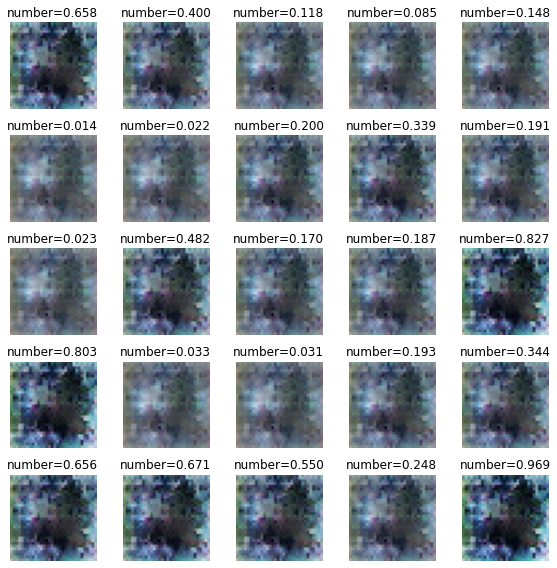

In [0]:
model = load_model('model_step5760.h5')
plt.figure(figsize=(8,8))

for i in range(25):
  plt.subplot(5,5, 1+i)
  num = float(rand(1))
  vector = asarray([[num for _ in range(100)]])
  # generate image
  X = model.predict(vector)
  text = "number={:4.3f}".format(num)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  plt.imshow(X[0,:,:,:])
  plt.title(text)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
from numpy import load
import os
from matplotlib import pyplot as plt


def load_single_image(image):
  img = img_to_array(image).reshape(1,32,32,3).astype('float32')
  return img/255.0

if not os.path.exists('malaria_3_class_data.npz'):
    !gsutil cp gs://pet-detect-239118/malaria_3_class_data.npz ./malaria_3_class_data.npz


# load the real images
def load_dataset():
   data = load('./malaria_3_class_data.npz')
   X = data['arr_0']
   Y = data['arr_1']
   return X, Y

images, labels = load_dataset()
print(images.shape)

(37230, 32, 32, 3)


In [0]:
!gsutil cp gs://pet-detect-239118/malaria_data.npz ./malaria_data.npz

Copying gs://pet-detect-239118/malaria_data.npz...
- [1 files][ 36.0 MiB/ 36.0 MiB]                                                
Operation completed over 1 objects/36.0 MiB.                                     


In [0]:
from numpy import load
from matplotlib import pyplot as plt

data = load('./malaria_data.npz')
dataset = data['arr_0']
labels = data['arr_1'] 

show_images = dataset[:25]
show_labels = labels[:25]

print(show_images.shape)
print(show_labels[0])


(25, 32, 32, 3)
[1 0]


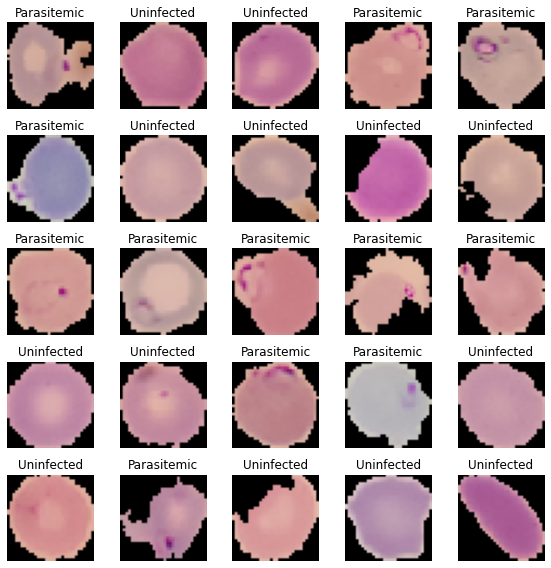

In [0]:
plt.figure(figsize=(8,8))

for i, image in enumerate(show_images):
  plt.subplot(5,5, 1+i)
  if show_labels[i][0] == 1:
    label = 'Parasitemic'
  else:
    label = 'Uninfected'
  plt.imshow(image)
  plt.axis('off')
  plt.title(label)

plt.tight_layout()
plt.show()

In [0]:
# load_fake_image
import numpy as np
from numpy.random import rand
def generate_fake_image(model, n_dim=100):
  num = float(rand(1))
  vector = asarray([[num for _ in range(n_dim)]])
  # generate image
  X = model.predict(vector)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  X = X *255

  X_image = np.asarray(X, dtype='uint8')
  return X_image[0,:,:,:]
  

Classify real images

In [0]:
def predict_single_image(image, rescale=False):
  CLASS_NAME = np.array(['Parasitemic', 'Uninfected', 'Unknown'])
  img = load_single_image(image)
  if rescale:
    img = img * 255
  classifier = load_model('RBC_classifier.h5')
  result = classifier.predict_classes(img)
  label = CLASS_NAME[result]
  return label[0]

(1000, 32, 32, 3)


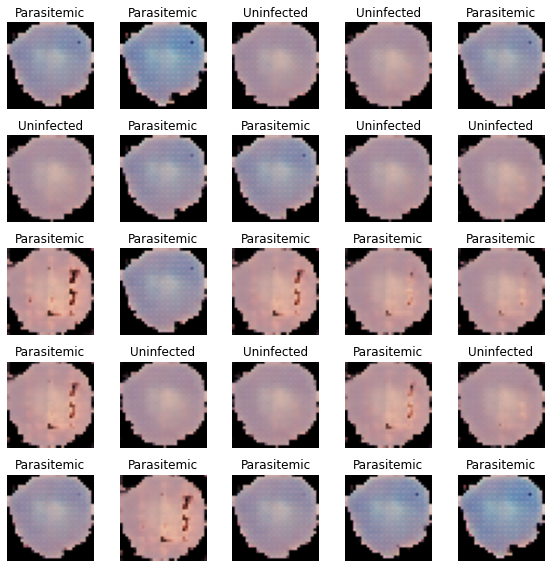

In [0]:
import numpy as np

generator = load_model('model_step2688_2.h5')
# generator = load_model('model_step4176.h5')
fake_set = []

for i in range(1000):
  fake_image = generate_fake_image(generator, n_dim=150)
  fake_set.append(fake_image)
fake_images = np.asarray(fake_set, dtype='uint8')
print(fake_images.shape)

plt.figure(figsize=(8,8))
classifier = load_model('RBC_classifier.h5')
CLASS_NAME = np.array(['Parasitemic', 'Uninfected', 'Unknown'])

# predict 25 images
pre_images = fake_images[600:625]
imgXs = pre_images.astype('float32')
imgXs = imgXs / 255.0
results = classifier.predict_classes(imgXs)

for i, image in enumerate(pre_images):
  plt.subplot(5,5, 1+i)
  tag = results[i]
  label = CLASS_NAME[tag]
  plt.imshow(image)
  plt.axis('off')
  plt.title(label)

plt.tight_layout()
plt.show()


In [0]:
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
import numpy as np
from skimage.transform import resize
from numpy import asarray
from tensorflow.keras.models import load_model

# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = []
  for image in images:
    new_image = resize(image, new_shape, 0)
    images_list.append(new_image)
  return asarray(images_list)

def calculate_inception_score(images, n_split=10, eps=1E-16):
  model = load_model('RBC_classifier.h5')
  # enumerate splits of images/predictions
  scores = []
  n_part = floor(images.shape[0] / n_split)
  for i in range(n_split):
    idx_start, idx_end = i * n_part, (i+1) * n_part
    subset = images[idx_start:idx_end]
    subset = subset.astype('float32')
    subset = scale_images(subset, (32,32,3))
    subset = subset / 255.0
    # predict p(y|x)
    p_yx = model.predict(subset)
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # calculate KL divergence using log probabilities
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the log
    is_score = exp(avg_kl_d)
    # store
    scores.append(is_score)
  # average across images
  is_avg, is_std = mean(scores), std(scores)
  return is_avg, is_std



In [0]:
# generator = load_model('model_step5760.h5')
generator = load_model('model_step2880.h5')
fake_set = []

for i in range(1000):
  fake_image = generate_fake_image(generator, n_dim=150)
  fake_set.append(fake_image)
fake_images = np.asarray(fake_set, dtype='uint8')

images = fake_images

# shuffle images
shuffle(images)
print('loaded: ', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)

loaded:  (1000, 32, 32, 3)
score 1.827328 0.031765312


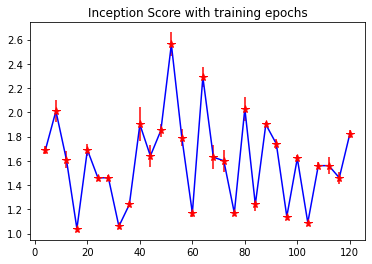

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60,
              64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120])

y = np.array([1.69, 2.01, 1.61, 1.04, 1.69, 1.46, 1.46, 1.06, 1.24, 1.90,
              1.64, 1.85, 2.56, 1.79, 1.17, 2.29, 1.63, 1.60, 1.17, 2.03,
              1.24, 1.90, 1.74, 1.14, 1.62, 1.09, 1.56,
              1.56, 1.46, 1.82])

e = np.array([0.03, 0.09, 0.07, 0.01, 0.05, 0.02, 0.02, 0.01, 0.01, 0.14,
              0.09, 0.05, 0.10, 0.07, 0.03, 0.08, 0.10, 0.09, 0.01, 0.10,
              0.05, 0.02, 0.04, 0.01, 0.03, 0.01, 0.03,
              0.07, 0.05, 0.03])

plt.plot(x,y, color='blue')
plt.title('Inception Score with training epochs')
plt.errorbar(x, y, e, linestyle='None', marker='*', color='red', markersize=8)

plt.show()

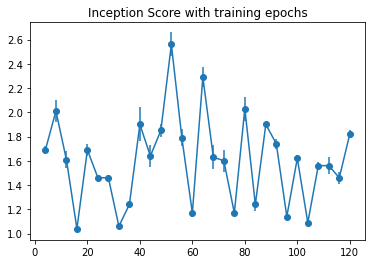

In [0]:
fig, (ax0) = plt.subplots(nrows=1, sharex=True)
ax0.errorbar(x, y, yerr=e, fmt='-o',)
ax0.set_title('Inception Score with training epochs')
plt.show()


ERROR! Session/line number was not unique in database. History logging moved to new session 59


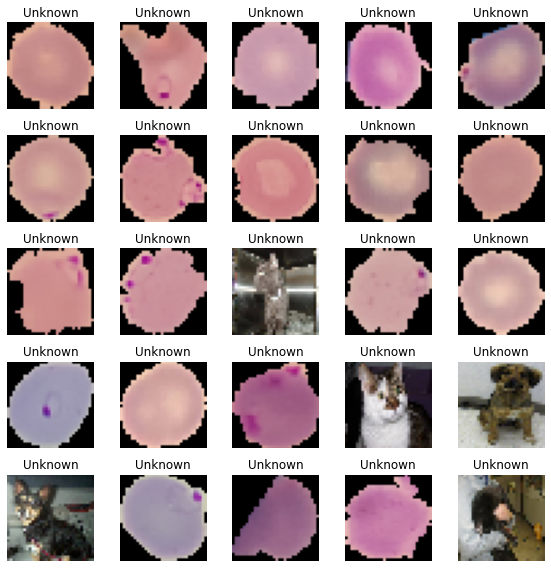

In [0]:
CLASS_NAME = np.array(['Parasitemic', 'Uninfected', 'Unknown'])
imgs = images[:25]
imgXs = imgs.astype('float32')
imgXs = imgXs / 255.0
classifier = load_model('RBC_classifier.h5')
results = classifier.predict_classes(imgs)

plt.figure(figsize=(8, 8))
for i, image in enumerate(images[:25]):
  plt.subplot(5, 5, i+1)
  plt.imshow(image)
  plt.title(CLASS_NAME[results[i]])
  plt.axis('off')

plt.tight_layout()
plt.show()

Classify fake image

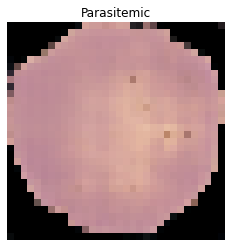

In [0]:
generator = load_model('model_step2880.h5')
num = float(rand(1))
vector = asarray([[num for _ in range(150)]])
# generate image
X = model.predict(vector)
X = X.reshape(32,32,3)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
label = predict_single_image(img)
plt.imshow(X)
plt.title(label)
plt.axis('off')
plt.show()

In [0]:
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from skimage.transform import resize
from numpy import asarray
from tensorflow.keras.models import load_model


# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = []
  for image in images:
    new_image = resize(image, new_shape, 0)
    images_list.append(new_image)
  return asarray(images_list)

def calculate_inception_score(images, n_split=10, eps=1E-16):
  model = load_model('RBC_classifier.h5')
  # enumerate splits of images/predictions
  scores = []
  n_part = floor(images.shape[0] / n_split)
  for i in range(n_split):
    idx_start, idx_end = i * n_part, (i+1) * n_part
    subset = images[idx_start:idx_end]
    subset = subset.astype('float32')
    subset = scale_images(subset, (32,32,3))
    subset = subset / 255.0
    # predict p(y|x)
    p_yx = model.predict(subset)
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # calculate KL divergence using log probabilities
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the log
    is_score = exp(avg_kl_d)
    # store
    scores.append(is_score)
  # average across images
  is_avg, is_std = mean(scores), std(scores)
  return is_avg, is_std

# load dataset
images, labels = load_dataset()
# shuffle images
shuffle(images)
print('loaded: ', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)


loaded:  (37230, 32, 32, 3)
score 2.9847896 0.0022354375
